In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle


In [2]:
vgecocup = tf.keras.models.load_model("models/vgecocup")
vgecocup.summary()

2022-06-07 22:27:30.875382: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
images_pos = os.listdir("dataset/train/images/pos/")
list_image_pos = []
for image in images_pos:
    list_image_pos.append(f"dataset/train/images/pos/{image}")
images_neg = os.listdir("dataset/train/images/neg/")
list_image_neg = []
for image in images_neg:
    list_image_neg.append(f"dataset/train/images/neg/{image}")
images = list_image_neg + list_image_pos
random.Random(20).shuffle(images)

files = os.listdir("dataset/train/labels_csv/")
labels = []
for file in files:
    labels.append(file[:-4])
    
df = pd.DataFrame(images, columns=["Image"])
df["label"] = df["Image"].apply(lambda x: 1 if x[25:-4] in labels else 0)
df

,Image,label
0,dataset/train/images/neg/wangruim_neg_005.jpg,0
1,dataset/train/images/neg/nivoixpa_neg_007.jpg,0
2,dataset/train/images/pos/oaitelhi_pos_002.jpg,1
3,dataset/train/images/pos/amiotnoe_pos_007.jpg,1
4,dataset/train/images/neg/oaitelhi_neg_001.jpg,0
...,...,...
771,dataset/train/images/pos/shiyujie_pos_001.jpg,1
772,dataset/train/images/neg/operezal_neg_002.jpg,0
773,dataset/train/images/neg/honhuhoa_neg_009.jpg,0
774,dataset/train/images/pos/smakhlou_pos_003.jpg,1


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df["Image"], df["label"], random_state=15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=15)

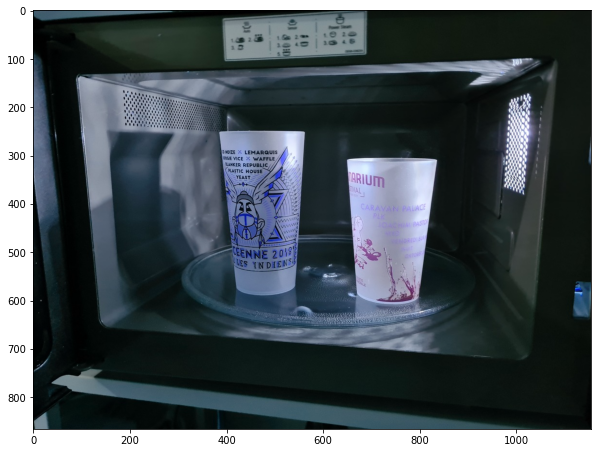

In [32]:
img = cv2.imread(X_val.iloc[1])
plt.figure(figsize=(10, 10))
plt.imshow(img)

In [33]:
picture_name = X_val.iloc[1][25:-4]
labels = pd.read_csv(f"dataset/train/labels_csv/{picture_name}.csv", header=None)
labels.columns=["y", "x", "h", "w", "class"]
labels

,y,x,h,w,class
0,247,383,345,180,0
1,303,649,308,188,0


In [34]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
ssresults.shape

(4824, 4)

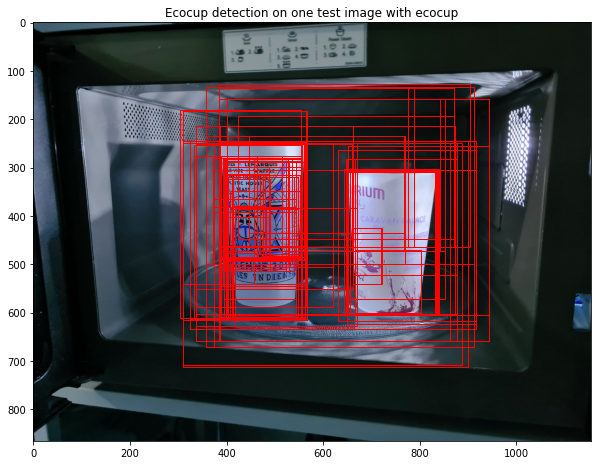

In [35]:
imout = img.copy()
figure, ax = plt.subplots(1, figsize=(10, 10))
best_result = 0
model_output = []
ax.imshow(img)
for i, boxes in enumerate(ssresults):
    x_result, y_result, w_result, h_result = boxes
    if h_result > 0.05*imout.shape[0] and w_result > 0.05*imout.shape[1]:
        test_image = imout[y_result:y_result+h_result, x_result:x_result+h_result]
        resized = cv2.resize(test_image, (224,224), interpolation = cv2.INTER_AREA)
        input_model = np.expand_dims(resized, axis=0)
        vgecocup_result = vgecocup.predict(input_model)
        if vgecocup_result[0][1] > 0.9:
            model_output.append(
                {
                    "x": x_result,
                    "y": y_result,
                    "w": w_result,
                    "h": h_result,
                    "score": vgecocup_result[0][1]
                }
            )
            rect = Rectangle((x_result,y_result),w_result,h_result, edgecolor='r', facecolor="none")
            ax.add_patch(rect)
plt.title("Ecocup detection on one test image with ecocup")
plt.show()

In [36]:
df_image_with_ecocup = pd.DataFrame(model_output)
df_image_with_ecocup

,x,y,w,h,score
0,649,306,189,298,0.999969
1,387,250,233,302,1.000000
2,337,250,539,408,1.000000
3,652,283,220,321,1.000000
4,652,306,185,266,0.994607
...,...,...,...,...,...
136,387,251,177,338,1.000000
137,325,245,591,389,1.000000
138,385,250,181,363,1.000000
139,337,250,226,362,1.000000


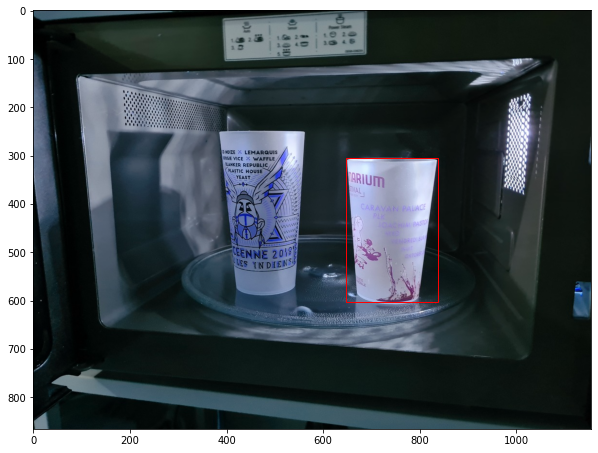

In [37]:
figure, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img)
rect = Rectangle((647,306),191,298, edgecolor='r', facecolor="none")
ax.add_patch(rect)
plt.show()